# 1. Install & Set Up Kaggle API

In [1]:
# ✅ Install Kaggle library
!pip install -q kaggle

# ✅ Upload kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anigasuresh","key":"31a963de6579c5b85ab23d3e35492c86"}'}

In [2]:
# ✅ Step 2: Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the two datasets from Kaggle into /content
!kaggle datasets download -d yashmotiani/dogs-skin-disease-dataset -p /content

Dataset URL: https://www.kaggle.com/datasets/yashmotiani/dogs-skin-disease-dataset
License(s): CC0-1.0
 91% 170M/188M [00:00<00:00, 432MB/s] 
100% 188M/188M [00:00<00:00, 483MB/s]


In [4]:
!unzip -q /content/dogs-skin-disease-dataset.zip -d /content


In [5]:
!pip install -q tensorflow matplotlib scikit-learn keras-cv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.2 MB/s eta 0:00:00


In [6]:
!pip install -q tensorflow keras

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
  # 1. 📦 Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # Added GlobalAveragePooling2D here


# 2. 📁 Dataset paths and constants
SPLIT_DIR = '/content/dog_skin_split'
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100

DATASET_BASE_DIR = "/content/Dogs"

train_dir = os.path.join(SPLIT_DIR, 'train')
val_dir = os.path.join(SPLIT_DIR, 'valid')
test_dir = os.path.join(SPLIT_DIR, 'test')


# ✂️ Split Dataset
print("Splitting dataset...")
if os.path.exists(SPLIT_DIR):
    shutil.rmtree(SPLIT_DIR)
os.makedirs(SPLIT_DIR)

all_image_paths = []
all_image_labels = []
for label in os.listdir(DATASET_BASE_DIR):
    label_dir = os.path.join(DATASET_BASE_DIR, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            all_image_paths.append(os.path.join(label_dir, img_name))
            all_image_labels.append(label)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_image_labels, test_size=0.2, random_state=42, stratify=all_image_labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.25, random_state=42, stratify=train_labels
)

for split_type in ['train', 'valid', 'test']:
    split_dir = os.path.join(SPLIT_DIR, split_type)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)
    for label in np.unique(all_image_labels):
        label_dir = os.path.join(split_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

for paths, labels, split_type in zip([train_paths, val_paths, test_paths], [train_labels, val_labels, test_labels], ['train', 'valid', 'test']):
    for img_path, label in zip(paths, labels):
        dest_dir = os.path.join(SPLIT_DIR, split_type, label)
        shutil.copy(img_path, dest_dir)
print("Dataset splitting complete.")


# 3. 📈 Load Generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_aug.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_aug.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# 4. ⚖️ Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

# 5. 🔄 Load Model (or build new if not found)
model_path = '/content/drive/My Drive/best_model.keras' # Using .keras format
if os.path.exists(model_path):
    print(f"✅ Model found at {model_path}. Loading it...")
    model = load_model(model_path)
else:
    print("✅ No existing model found. Building a new MobileNetV2 model...")
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(train_gen.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

# 6. 🧠 Fine-tuning: Unfreeze some layers (if loading existing model) or all (if new model)
if os.path.exists(model_path):
    print("Unfreezing all layers for fine-tuning...")
    for layer in model.layers:
        layer.trainable = True
    # Recompile with lower learning rate for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()


# 7. 📍 Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# 8. 🚀 Train/Continue Training
print("\n🚀 Training the model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint,lr_scheduler] #early_stop]
)

# 9. 📉 Evaluation
print("\n📈 Evaluating on Test Data...")
loss, accuracy = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {accuracy:.2f}")



Splitting dataset...
Dataset splitting complete.
Found 262 images belonging to 4 classes.
Found 89 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
✅ Model found at /content/drive/My Drive/best_model.keras. Loading it...
Unfreezing all layers for fine-tuning...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 2,228,996 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)


🚀 Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 5:56 45s/step - accuracy: 0.8333 - loss: 0.4281

In [13]:
model.save('/content/drive/My Drive/best_model.keras')


In [10]:
!ls "/content/drive/My Drive/best_model.keras"


'/content/drive/My Drive/best_model.keras'


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

 Classification Report:

                                      precision    recall  f1-score   support

                Bacterial_dermatosis       0.94      0.83      0.88        18
                   Fungal_infections       0.96      0.89      0.93        28
                             Healthy       0.85      0.96      0.90        24
Hypersensitivity_allergic_dermatosis       0.84      0.89      0.86        18

                            accuracy                           0.90        88
                           macro avg       0.90      0.89      0.89        88
                        weighted avg       0.90      0.90      0.90        88



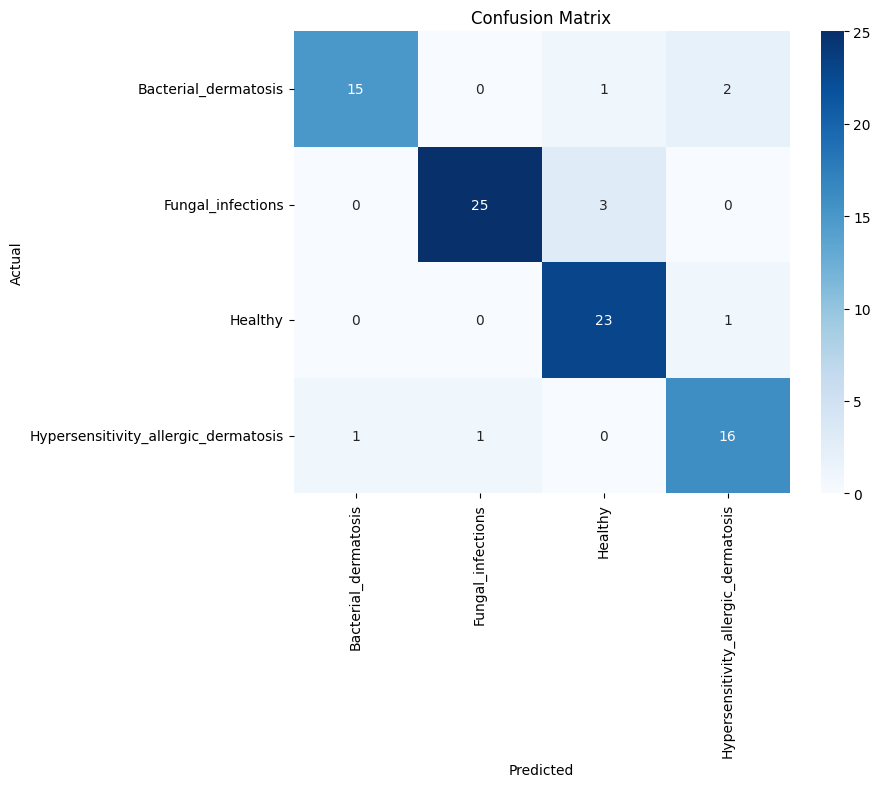

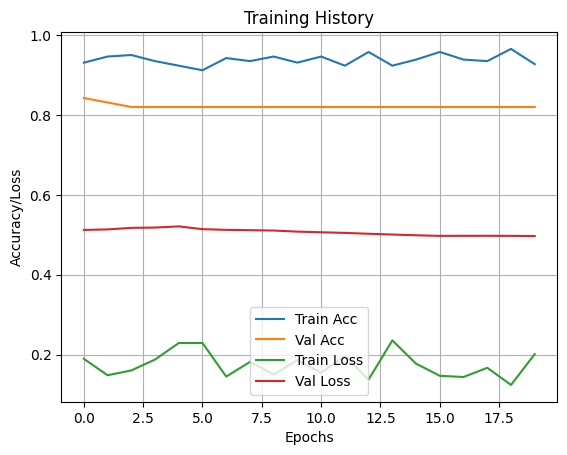

In [11]:
# Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix # Import classification_report and confusion_matrix
import matplotlib.pyplot as plt # Import matplotlib
import seaborn as sns # Import seaborn
import numpy as np # Import numpy

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#  Plot training history
# Note: The 'history' object is generated in the training cell (z2MWeyE34r8-).
# If you run this cell independently, you'll need to ensure 'history' is available.
# For this fix, we assume 'history' is available from a previous execution.
if 'history' in locals():
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    plt.title("Training History")
    plt.grid(True)
    plt.show()
else:
    print("Training history not available. Please run the training cell first.")

✅ Model loaded successfully.
📤 Please upload an image:


Saving hy.jpg to hy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

✅ Uploaded Image: hy.jpg
🤖 Predicted Class: Fungal_infections


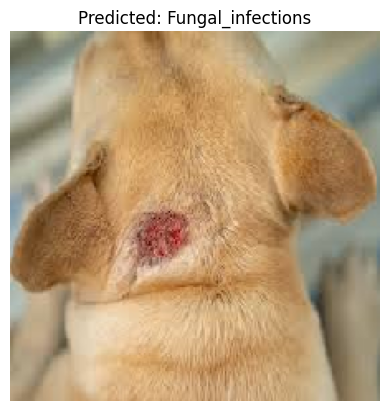

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from google.colab import files
from PIL import Image

# Load trained model (.keras or .h5 file)
model = load_model('/content/best_model.keras')  # change path if needed
print("✅ Model loaded successfully.")

# Define class labels (ensure order matches your model's training)
class_labels = ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']

# Upload an image
print("📤 Please upload an image:")
uploaded = files.upload()

# Process and predict on the uploaded image(s)
for img_name in uploaded.keys():
    # Load and preprocess image
    img_path = img_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict using loaded model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    # Display results
    print(f"\n✅ Uploaded Image: {img_path}")
    print(f"🤖 Predicted Class: {predicted_label}")

    # Show image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
